# Problem Statement

### Imagine you have a dataset where you have different categories of data, Now you need to find the most similar data to the given data by using any 4 different similarity algorithms. Now you have to build a model which can find the most similar data to the given data.


In [1]:
#import necessory library
import numpy as np
import pandas as pd
import json
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

# libraries for text processing using NLTK
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# libraries  for feature representation using sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# libraries for similarity matrices using sklearn
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances

In [2]:
#read data
df = pd.read_json('../dataset/News_Category_Dataset_v3.json',lines=True)

In [3]:
df.head(2)

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


### Data Preprocessing & EDA

In [5]:
#Removing all the short headline articles

In [6]:
df = df[df['headline'].apply(lambda x: len(x.split())>5)]

In [7]:
print("Total number of articles after removal of headlines with short title:", df.shape[0])

Total number of articles after removal of headlines with short title: 189196


In [8]:
#Checking and removing all the duplicates

In [9]:
df.sort_values('headline',inplace=True, ascending=False)

In [10]:
df.duplicated('headline', keep = False).sum()

1808

In [11]:
duplicated_articles = df.duplicated('headline', keep = False)

In [12]:
df = df[~duplicated_articles]
print("Total number of articles after removing duplicates:", df.shape[0])

Total number of articles after removing duplicates: 187388


In [13]:
#Checking for missing values

In [14]:
df.isna().sum()

link                 0
headline             0
category             0
short_description    0
authors              0
date                 0
dtype: int64

In [15]:
print("Total number of articles : ",df.shape[0])
print("Total number of authors : ", df["authors"].nunique())
print("Total number of unqiue categories : ", df["category"].nunique())

Total number of articles :  187388
Total number of authors :  25765
Total number of unqiue categories :  42


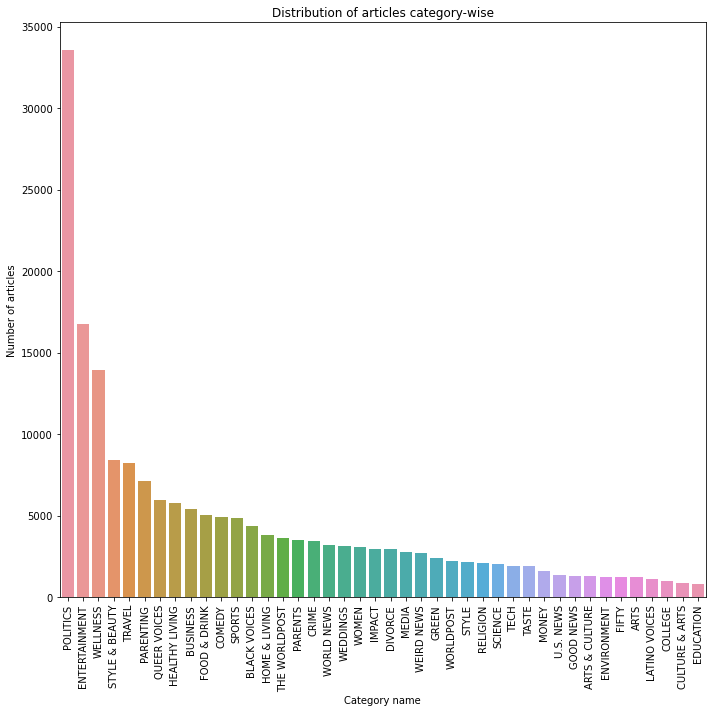

In [16]:
plt.figure(figsize=(10,10))
sns.barplot(x=df["category"].value_counts().index, y=df["category"].value_counts().values)
plt.title("Distribution of articles category-wise")
plt.xlabel("Category name")
plt.ylabel("Number of articles")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

- From the bar chart, we can observe that `politics` category has highest number of articles then entertainment and so on.

In [17]:
#Number of articles per month

In [18]:
news_articles_per_month = df.resample('m',on = 'date')['headline'].count()
news_articles_per_month

date
2012-01-31     279
2012-02-29    2158
2012-03-31    2241
2012-04-30    2206
2012-05-31    2355
              ... 
2022-05-31     171
2022-06-30     146
2022-07-31     142
2022-08-31     173
2022-09-30     127
Freq: M, Name: headline, Length: 129, dtype: int64

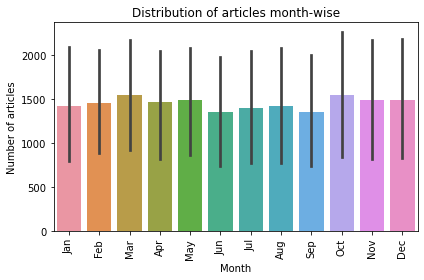

In [19]:
sns.barplot(x=news_articles_per_month.index.strftime("%b"), y=news_articles_per_month)
plt.title("Distribution of articles month-wise")
plt.xlabel("Month")
plt.ylabel("Number of articles")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

- From the bar chart, we can observe that March month has highest number of articles.

In [20]:
#PDF for the length of headlines

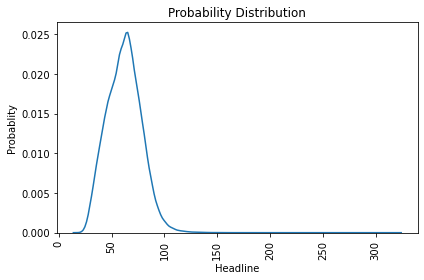

In [21]:
sns.kdeplot(x =df['headline'].str.len() )
plt.title("Probability Distribution")
plt.xlabel("Headline")
plt.ylabel("Probablity")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

- The probability distribution function of headline length is almost similar to a Guassian distribution(right skewed due to outlier), where most of the headlines are 40 to 80 words long in length.

In [22]:
#Adding a new column containing both day of the week and month, it will be required later while recommending based on day of the week and month

In [23]:
df["day and month"] = df["date"].dt.strftime("%a") + "_" + df["date"].dt.strftime("%b")

In [24]:
data = df.copy()

### Text Preprocessing

In [25]:
#1.Stopwords removal

In [26]:
data.head()

,link,headline,category,short_description,authors,date,day and month
44964,https://www.huffingtonpost.com/entry/we-shall-...,"“We Shall Overcomb!” Say The 100,000 Marching ...",WOMEN,Thousands of activists descended on London to ...,"Darin Graham, ContributorJournalist",2017-01-25,Wed_Jan
29868,https://www.huffingtonpost.com/entry/to-the-bo...,“To The Bone” Didn’t Teach Me Glamour. It Taug...,HEALTHY LIVING,"Oftentimes, films or TV shows about eating dis...","Mycah Hazel, Contributorblogger, equal opportu...",2017-07-18,Tue_Jul
38346,https://www.huffingtonpost.com/entry/im-sorryt...,"“I’m Sorry""--The Two Tragically Forgotten Word...",BUSINESS,"Unfortunately, I was one of those frustrated p...","Dana Brownlee, ContributorPresident of Profess...",2017-04-10,Mon_Apr
2565,https://www.huffpost.com/entry/nsync-backstree...,’N Sync's Chris Kirkpatrick Says He 'Couldn't ...,ENTERTAINMENT,The former boy banders apparently did not like...,Jenna Amatulli,2021-06-09,Wed_Jun
1740,https://www.huffpost.com/entry/jim-bob-duggar-...,’19 Kids And Counting’ Father Running For Arka...,POLITICS,"Jim Bob Duggar, who previously served in the A...",,2021-10-31,Sun_Oct


In [27]:
data.reset_index(inplace=True)

In [28]:
stop_words = set(stopwords.words('english'))

In [29]:
for i in range(len(data["headline"])):
    string = ""
    for word in data["headline"][i].split():
        word = ("".join(e for e in word if e.isalnum()))
        word = word.lower()
        if not word in stop_words:
            string += word + " "  
    if(i%1000==0):
        print(i)           # To track number of records processed
    data.at[i,"headline"] = string.strip()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [30]:
#Lemmatization

In [31]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\anike\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [32]:
lemmatizer = WordNetLemmatizer()

In [33]:
for i in range(len(data["headline"])):
    string = ""
    for w in word_tokenize(data["headline"][i]):
        string += lemmatizer.lemmatize(w,pos = "v") + " "
    data.at[i, "headline"] = string.strip()
    if(i%1000==0):
        print(i)           # To track number of records processed

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


### Headline based similarity on new articles

### 1.BOW

In [34]:
headline_vectorizer = CountVectorizer()
headline_features   = headline_vectorizer.fit_transform(data['headline'])

In [35]:
headline_features.get_shape()

(187388, 58064)

In [36]:
pd.set_option('display.max_colwidth', -1)  # To display a very long headline 

C:\Users\anike\AppData\Local\Temp\ipykernel_10132\2847209856.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)  # To display a very long headline


### 1.1 Euclidean distance

In [37]:
def bag_of_words_based_model(row_index, num_similar_items):
    couple_dist = pairwise_distances(headline_features,headline_features[row_index])
    indices = np.argsort(couple_dist.ravel())[0:num_similar_items]
    df = pd.DataFrame({'publish_date': data['date'][indices].values,
               'headline':data['headline'][indices].values,
                'Euclidean similarity with the queried article': couple_dist[indices].ravel()})
    print("="*30,"Queried article details","="*30)
    print('headline : ',data['headline'][indices[0]])
    print("\n","="*25,"Recommended articles : ","="*23)
    #return df.iloc[1:,1]
    return df.iloc[1:,]
bag_of_words_based_model(100, 6)

============================== Queried article details ==============================
headline :  rupauls drag race star 3 episode 2 recap sour milk

 ========================= Recommended articles :  =======================


,publish_date,headline,Euclidean similarity with the queried article
1,2018-02-16,rupauls drag race star 3 episode 4 recap snatch game,2.000000
2,2018-02-12,rupauls drag race star 3 episode 3 recap bitchelors heart,2.000000
3,2018-03-02,rupauls drag race star 3 episode 6 recap queen return competition,2.236068
4,2015-02-25,6 question milk rupauls drag race,2.236068
5,2018-03-16,rupauls drag race star 3 episode 8 recap queen snatch crown,2.236068


### 1.2 Cosine similaity

In [38]:
def bag_of_words_based_model(row_index, num_similar_items):
    cosine_similarities = pairwise_distances(headline_features, headline_features[row_index], metric='cosine')
    indices = np.argsort(cosine_similarities.ravel())[1:num_similar_items + 1]
    df = pd.DataFrame({
        'publish_date': data['date'][indices].values,
        'headline': data['headline'][indices].values,
        'Cosine similarity with the queried article': 1 - cosine_similarities[indices].ravel()
    })
    print("=" * 30, "Queried article details", "=" * 30)
    print('headline:', data['headline'][indices[0]])
    print("\n", "=" * 25, "Recommended articles:", "=" * 23)
    return df
bag_of_words_based_model(100, 6)

============================== Queried article details ==============================
headline: rupauls drag race star 3 episode 3 recap bitchelors heart

 ========================= Recommended articles: =======================


,publish_date,headline,Cosine similarity with the queried article
0,2018-02-12,rupauls drag race star 3 episode 3 recap bitchelors heart,0.750000
1,2018-02-16,rupauls drag race star 3 episode 4 recap snatch game,0.750000
2,2018-03-16,rupauls drag race star 3 episode 8 recap queen snatch crown,0.707107
3,2018-03-02,rupauls drag race star 3 episode 6 recap queen return competition,0.707107
4,2018-03-09,rupauls drag race star 3 episode 7 recap never go back,0.707107
5,2018-01-29,rupauls drag race star 3 episode 1 recap queen go home first,0.670820


### 2.TF-IDF method

In [39]:
tfidf_headline_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_headline_features = tfidf_headline_vectorizer.fit_transform(data['headline'])

### 2.1 Euclidean Distance

In [40]:
def tfidf_based_model(row_index, num_similar_items):
    couple_dist = pairwise_distances(tfidf_headline_features,tfidf_headline_features[row_index])
    indices = np.argsort(couple_dist.ravel())[0:num_similar_items]
    df = pd.DataFrame({'publish_date': data['date'][indices].values,
               'headline':data['headline'][indices].values,
                'Euclidean similarity with the queried article': couple_dist[indices].ravel()})
    print("="*30,"Queried article details","="*30)
    print('headline : ',data['headline'][indices[0]])
    print("\n","="*25,"Recommended articles : ","="*23)
    
    #return df.iloc[1:,1]
    return df.iloc[1:,]
tfidf_based_model(100, 6)

============================== Queried article details ==============================
headline :  rupauls drag race star 3 episode 2 recap sour milk

 ========================= Recommended articles :  =======================


,publish_date,headline,Euclidean similarity with the queried article
1,2018-03-09,rupauls drag race star 3 episode 7 recap never go back,0.748234
2,2018-01-29,rupauls drag race star 3 episode 1 recap queen go home first,0.791310
3,2018-02-16,rupauls drag race star 3 episode 4 recap snatch game,0.794625
4,2018-03-02,rupauls drag race star 3 episode 6 recap queen return competition,0.820942
5,2015-02-25,6 question milk rupauls drag race,0.840004


### 2.2 Cosine Similarity

In [41]:
def bag_of_words_based_model(row_index, num_similar_items):
    cosine_similarities = pairwise_distances(headline_features, headline_features[row_index], metric='cosine')
    indices = np.argsort(cosine_similarities.ravel())[1:num_similar_items + 1]
    df = pd.DataFrame({
        'publish_date': data['date'][indices].values,
        'headline': data['headline'][indices].values,
        'Cosine similarity with the queried article': 1 - cosine_similarities[indices].ravel()
    })
    print("=" * 30, "Queried article details", "=" * 30)
    print('headline:', data['headline'][indices[0]])
    print("\n", "=" * 25, "Recommended articles:", "=" * 23)
    return df
bag_of_words_based_model(100, 6)

============================== Queried article details ==============================
headline: rupauls drag race star 3 episode 3 recap bitchelors heart

 ========================= Recommended articles: =======================


,publish_date,headline,Cosine similarity with the queried article
0,2018-02-12,rupauls drag race star 3 episode 3 recap bitchelors heart,0.750000
1,2018-02-16,rupauls drag race star 3 episode 4 recap snatch game,0.750000
2,2018-03-16,rupauls drag race star 3 episode 8 recap queen snatch crown,0.707107
3,2018-03-02,rupauls drag race star 3 episode 6 recap queen return competition,0.707107
4,2018-03-09,rupauls drag race star 3 episode 7 recap never go back,0.707107
5,2018-01-29,rupauls drag race star 3 episode 1 recap queen go home first,0.670820
